**Projet réalisé en binôme par:**
- Samy Khlifi
- Wissal Belhorma

**Objectifs du projet:**

  Comparer le modèle markovien et le modèle déterministe SIR de la diffusion d'une épidémie. 

$$ \ **Sommaire**$$
**1) Résolution du système déterministe SIR avec $\beta$ et $\gamma$ données.**

**2) Simulation du modèle markovien pour une population de N individus.**

**3) Couple de valeurs($\beta$ , $\gamma$ ) demandés**

**4) Comparaison des modèles.**

**5) Etude de la convergence du modèle markovien.**

**6)estimation des paramètres gamma et beta sur un département donné à partir des données sur COVID**

 ## **1) Résolution du système déterministe SIR avec $\beta$ et $\gamma$ données:**

$\ Présentation \ du \ système \ déterministe \ SIR$

Soit le processus $X(t) = (S(t), I(t), R(t))$

soit une population de $N$ individus partitionnée en trois catégories :
- $S(t)$ : Les susceptibles d'etre contaminés.
- $I(t)$ : ceux qui sont contaminés.
- $R(t)$ : les retirés (les immunisés ou les décédés).

On suppose que $S(t) + I(t) + R(t) = N+1$ pour tout t , c'est-à-dire la somme reste constante et que dans l'état initial il y a un seul infecté : $$ \ 
S(t) = N, I(t) = 1, R(t) = 0 $$

>> paramètres du problème :
- $\beta > 0 $ Le taux de transmission de la maladie
- $\gamma > 0 $ le taux de récupération,i.e le taux auquel les individus infectés récupèrent et deviennent immunisés ou retirés de la population infectieuse.

Le système d'équation du modèle est donné :
$$\left\lbrace\begin{array}{c} \frac{dS}{dt} = -\beta S I \\
\frac{dI}{dt} = \beta S I -\gamma I \\
\frac{dR}{dt} = \gamma I
\end{array}\right.$$

sous les contraintes $S(t) \geq 0$, $I(t) \geq 0$ and $R(t) \geq 0$


$ \ Résolution \ du \ système $

In [55]:
#Toutes les importations nécessaires seront ici
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import csv
#import pandas as pd
from scipy.interpolate import interp1d



Il s'agit ici de la résolution d'un problème de Cauchy: $y'=f(t,y(t))$, la fonction f est ainsi définie dans le code ci dessous:

In [56]:
def SIR(x ,t,beta , gamma , N ):
    s = x[0]
    i = x[1]
    r = x[2]
    dsdt = -beta * s * i / N
    didt = beta * s * i / N - gamma * i
    drdt = gamma * i
    l=[dsdt ,didt,drdt]
    
    return np.array(l)


Pour résoudre l'équation differentielle on a choisit la méthode d'Euler à un pas 

In [57]:
def Euler(x0, t0, tN, f, steps, N):

    t = np.linspace(t0, tN, steps + 1)

    # Defining the steps h
    h = t[1]-t[0]

    # Computing the values of y and storing them
    d = len(x0)
    y = np.zeros((steps + 1, d))
    y[0] = x0
    for i in range(steps):
        y[i + 1] = y[i] + h*f(y[i], t[i] ,beta , gamma , N)
    return y


In [58]:
# Parameters
population = 3000+ 1 # Population
s0 = population - 1 # Initial susceptible
i0 = 1 # Initial infected
r0 = 0 # Initial recovered
beta = 2 # Contagion rate
gamma = 1 # Recovery rate
t0 = 0
tN = 30
steps = 3000
x0=[s0 , i0 ,r0]

In [59]:
# Computation
t = np.linspace(t0, tN, steps + 1)
p = Euler(x0, t0, tN, SIR, steps, population)


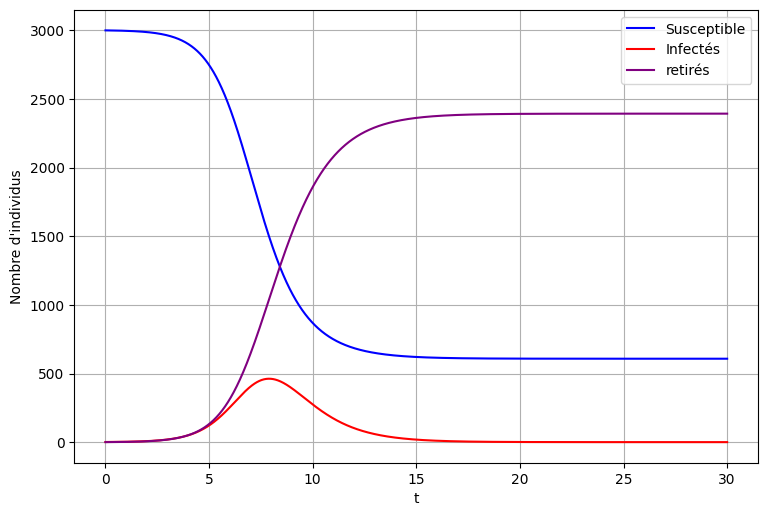

In [60]:
# Tracé de courbe
plt.figure(figsize=(30, 20))
plt.subplot(3, 3, 1)
plt.plot(t, p[:, 0],color='blue',label='Susceptible')
plt.plot(t, p[:, 1], color='red',label='Infectés')
plt.plot(t, p[:, 2], color='purple',label='retirés')
plt.xlabel("t")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.grid()
plt.show()

## 2) **Simulation du modèle markovien pour une population de N individus:**



L'espace d'état du processus de markov est :  

$$
E = \{ n = (n_1, n_2, n_3) \mid \ n_1+ n_2+ n_3 = N+1 \}
$$
 avec N+1 est le nombre d'individus dans notre population.

Chaque état est écrit sous la forme d'un vecteur $ n = (n_1, n_2, n_3) $ avec :
>$n_1 $ : le nombre d'individu susceptible.

>$n_2 $ : le nombre d'individus infectieux.

>$n_3 $ : le nombre d'individus retirés.

On distingue donc nos 3 états dans notre processus de Markov, ***1*** pour  susceptibles, ***2*** pour infectieus, et ***3*** pour retirés

Reste à définir les taux pour chaque transition d'un état d'espace à autre.


Dans ce processus, seule deux transitions sont possibles:
La transition de l'état ***1*** à l'état ***2***, et la transition de l'état ***2*** à l'état ***3***:

$$(n_1, n_2, n_3)   \rarr (n_1-1, n_2+1 , n_3)\  avec\ un\ taux\ : \beta n_2n_1\frac{1}{N} \mathbb{1}_{n_1 > 0} $$

$$(n_1, n_2, n_3)   \rarr (n_1, n_2-1 , n_3+1)\  avec\ un\ taux\ : \gamma n_2\mathbb{1}_{n_2 > 0} $$





In [61]:
#Calibration du modèle
gamma=1
béta=2
N=3000


In [62]:
# Cette fonction définit l'indicatrice sur l'événement n1>0    
def indicatrice_s(n):
    if n[0]>0:
        return 1
    else:
        return 0

In [63]:
# Cette fonction définit l'indicatrice sur l'événement n2>0    
def indicatrice_i(n):
    if n[1]>0:
        return 1
    else:
        return 0

In [64]:
# La matrice de transition Q
def Q(n , béta,gamma):
    return ([[0,béta*n[0]*n[1]*indicatrice_s(n)*(1/N),0]
           ,[0,0,n[1]*indicatrice_i(n)*gamma]
           ,[0,0,0]])


La transition à effectuer sera choisie aléatoirement selon la distribution de probabilité donnée par ($\frac{Q_{12}}{Q_{12}+Q_{23}}$,$\frac{Q_{23}}{Q_{12}+Q_{23}}$)

In [65]:
# Cette fonction construit la distribution de probabilité mentionée en haut.
def distribution(n,béta,gamma):
    sum=Q(n,béta,gamma)[0][1]+Q(n,béta,gamma)[1][2]
    return[Q(n,béta,gamma)[0][1]/sum,Q(n,béta,gamma)[1][2]/sum]
    

In [66]:
# Cette fonction choisit et effectue la transition selon la distribution de probablité mentionnée en haut.

def transition(n,béta,gamma):
    next_state=np.random.choice([1,2],p=distribution(n,béta,gamma)) #les 2 éléments de la liste représentent les 2 transitions possibles
    match next_state:
        case 1: # transition de l'état 1 à 2
            n[0]-=1
            n[1]+=1
        case 2: # transition de l'état 2 à 3
            n[1]-=1
            n[2]+=1
           
    return n
      
 

In [67]:
# Cette fonction simule le processus de Markov, elle retourne deux listes:
        # T: temps de transitions.
        # Ni: transitions correspondantes.
def trajectoire(n_initial,T_final,béta,gamma):
    T=[0] # cette variable contiendra les temps de transitions
    Ni=[n_initial] # cette variable contiendra tous les états et nous sera utile pour suivre l'évolution de notre processus
    while T[-1]<T_final and (Q(Ni[-1],béta,gamma)[0][1]+Q(Ni[-1],béta,gamma)[1][2])!=0: 
       
        T+=[T[-1] + np.random.exponential(1/(Q(Ni[-1],béta,gamma)[0][1]+Q(Ni[-1],béta,gamma)[1][2]))] # le temps entre deux transitions consécutives suit une loi exponentielle
        x=transition(Ni[-1],béta,gamma)
        Ni.append(x.copy())
        
    return T,Ni

Si on choisit un seul infecté et vue le caractère aléatoire du processus, on peut avoir le résulat suivant avec une probabilité qui est non négligeable dans notre cas.

$$état\ initial\ : (N,1,0)$$
$$état\ 1: (N,0,1)$$

Et l'état 1 est un état à partir duquel aucune transition n'est possible.

Pour éviter ceci , on choisit de commmencer avec **10 infectés**, ceci garantit avec une très grande probabilité la propagation du virus.

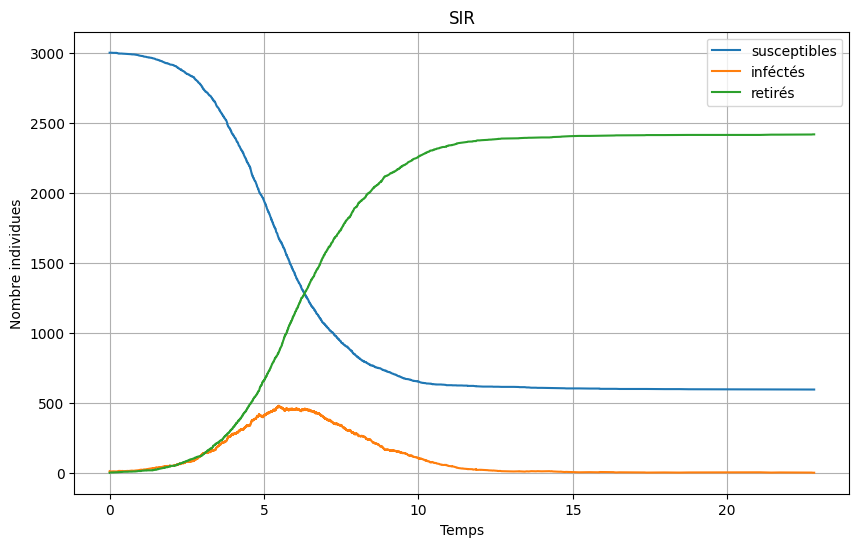

In [68]:
T,L = trajectoire([N,10,0],200,béta,gamma) 

#Tracé des courbes d'évolution des colonies
variable_1 = [item[0] for item in L]
variable_2 = [item[1] for item in L]
variable_3 = [item[2] for item in L]


plt.figure(figsize=(10, 6))
plt.plot(T, variable_1, label='susceptibles')
plt.plot(T, variable_2, label='inféctés')
plt.plot(T, variable_3, label='retirés')

plt.xlabel('Temps')
plt.ylabel('Nombre individues')
plt.title('SIR')
plt.legend()
plt.grid(True)
plt.show()

## **3) Couple de valeurs ($\beta$ , $\gamma$ ) demandées:**

>Cas tout le monde est retiré sur le long terme

On a $\beta$ c'est le taux de transmission de la maladie , et $\gamma$ c'est le taux de retrait (par décès ou rétablissement) 

Pour que tout le monde soit retiré sur le long terme il faut que tout le monde soit d'abord infecté donc le taux de transmission de la maladie $\beta$ doit être augmenté, et avec l'augmentation de $\beta$ , il faut diminuer $\gamma$ le taux de retiration car sinon les infectés seront vite retirés avant même qu'ils puissent transmettre la maladie à un nouveau individu.



Le code nous permet de choisir le Couple de valeurs($\beta_l$ , $\gamma_l$ ) limite tel que tout le monde est retiré sur le long terme(en partant de valeurs initiales de gamma et béta)

Donc touts les couples de valeurs de l'intervalle ([$\beta_l$ ,∞[ ; [0,$\gamma_l$] )


In [69]:
beta0 = 3 # Contagion rate
gamma0 = 1 # Recovery rate

def couple_valeur(beta0,gamma0,pas):
    
    T,L = trajectoire([N,1,0],200,beta0,gamma0)
    gamma=gamma0
    while L[-1]!=[0,0,N+1] and gamma > 0 :
        beta = beta0 + pas
        gamma = gamma0 - pas/4
        T,L = trajectoire([N,1,0],200,beta,gamma)
        
        
    return beta , gamma   

#(6.7, 0.65)
beta_l , gamma_l=couple_valeur(beta0,gamma0,1.5) 
print("valeurs de (beta_l , gamma_l ) est : " ,(beta_l , gamma_l ))   

valeurs de (beta_l , gamma_l ) est :  (4.5, 0.625)


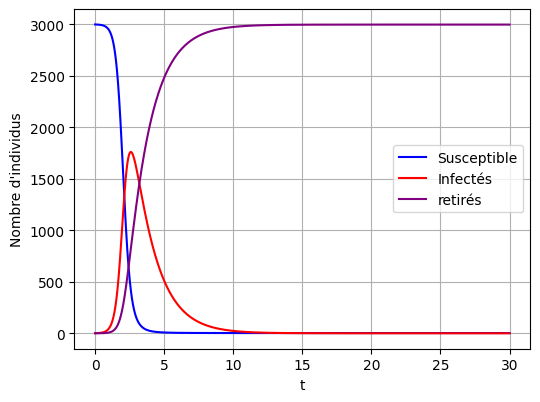

In [70]:
# On utlise les valeurs trouvées précédament.
x = odeint(SIR, [N , 1 ,0], t, args=(4.5 , 0.625,N+1))

# Plotting
plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
plt.plot(t, x[:, 0],color='blue',label='Susceptible')
plt.plot(t, x[:, 1], color='red',label='Infectés')
plt.plot(t, x[:, 2], color='purple',label='retirés')
plt.xlabel("t")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.grid()
plt.show()


On voit bien que pour $\beta=4.5$ et $\gamma=0.625$, toutes la population est retirée vers la fin.

Une autre méthode possible c'est de fixer $\beta$ et de diminuer $\gamma$ ou de fixer  $\gamma$  et augmenter $\beta$ jusqu'à ce que tout le monde soit retiré 

>Cas il y a une partie de la population qui reste susceptible et une autre qui est retirée 

Il faut avoir un état équilibré donc $\beta$ pas trop grand et $\gamma$ pas trop petit pour ne pas tomber dans le cas précédent , déja le complémentaire des intervalles précedents permet d'avoir le comportement demandé. Il faut en plus que $\beta$ > $\gamma$ car sinon les infectés seront vite retirés avant qu'ils transmettent la maladie aux autres individus .

**Exemple de valeurs ($\beta$ , $\gamma$) tel que une partie de la population reste susceptible et une autre est retirée**

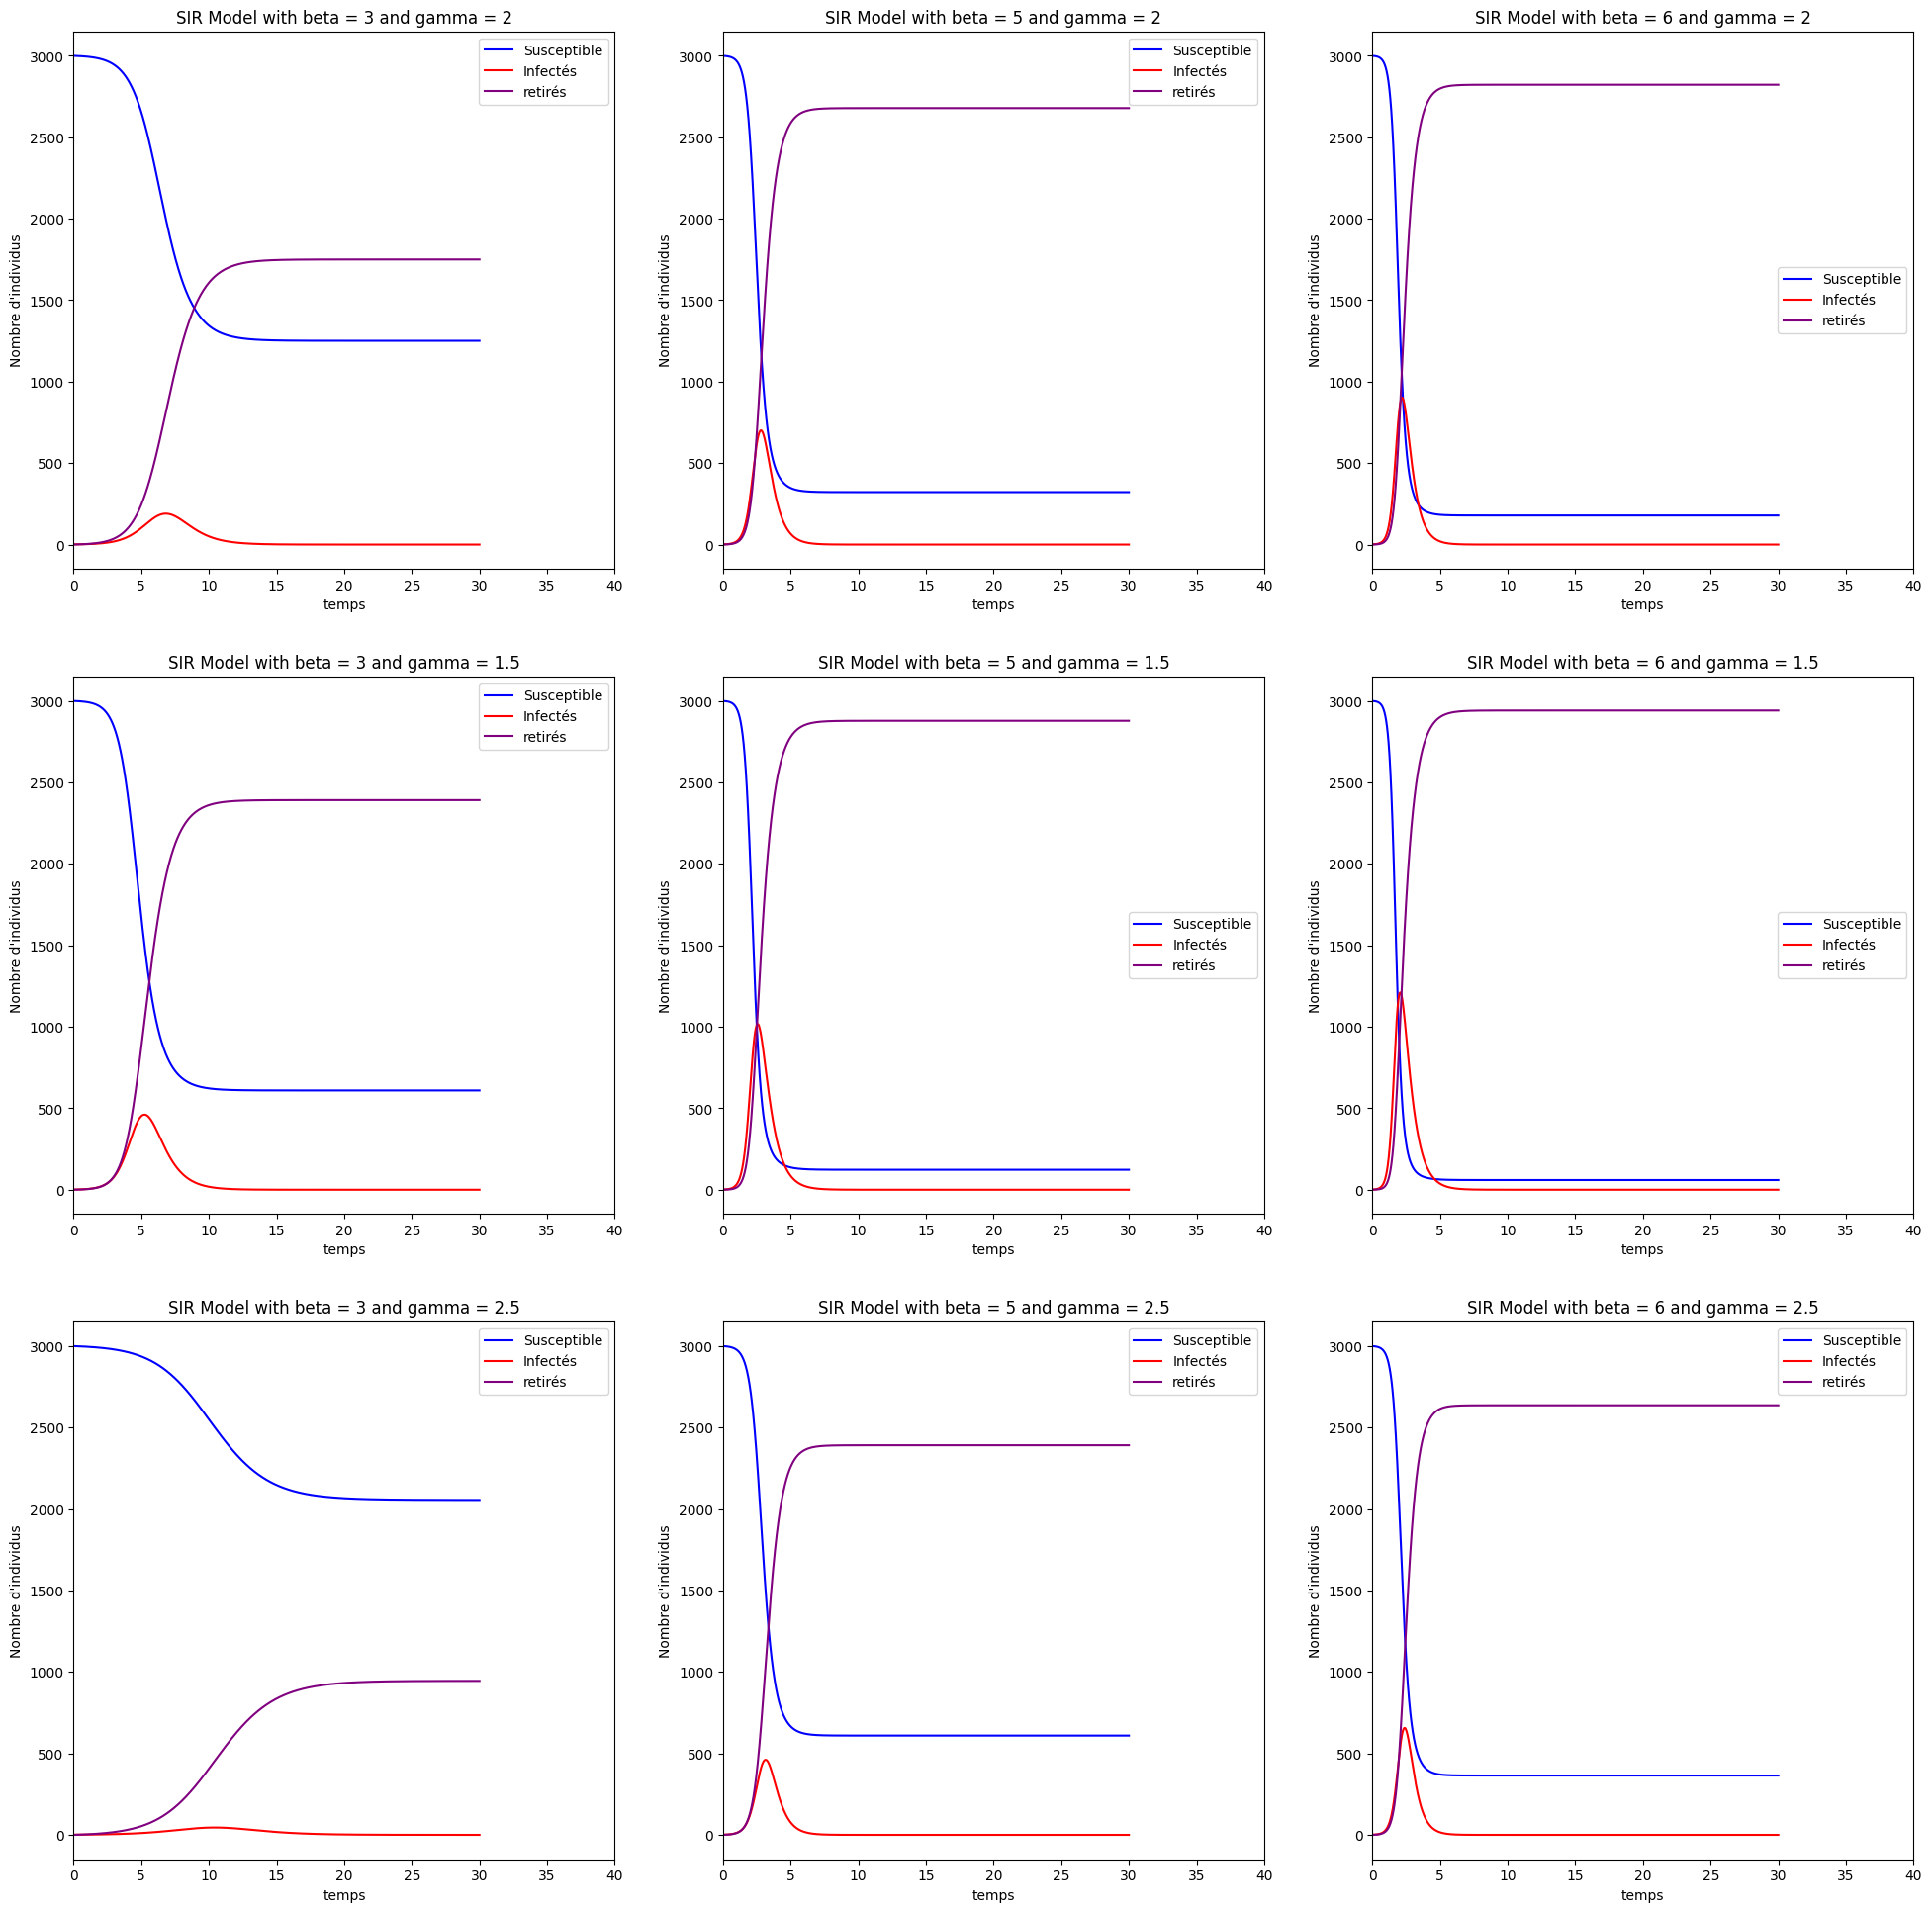

In [71]:

beta_list = [3, 5, 6]
gamma_list = [2, 1.5, 2.5]
fig, axs = plt.subplots(3, 3, figsize=(24, 24))


for c, g in enumerate(gamma_list):
    for b, be in enumerate(beta_list):
        x = odeint(SIR, [N , 1 ,0], t, args=(be , g,N+1))
        axs[c, b].plot(t, x[:, 0],color='blue',label='Susceptible')
        axs[c, b].plot(t, x[:, 1], color='red',label='Infectés')
        axs[c, b].plot(t, x[:, 2], color='purple',label='retirés')
        axs[c, b].set_xlim(0, 40)
        axs[c, b].set_xlabel('temps')
        axs[c, b].set_ylabel("Nombre d'individus")
        axs[c, b].set_title('SIR Model with beta = {} and gamma = {}'.format(be, g))
        axs[c, b].legend()
        
plt.show()

On remarque donc qu'il faut avoir $\gamma$ inférieur mais du même ordre de grandeur que $\beta$ pour avoir une partie retirée et une partie susceptible

## **4) Comparaison des modèles:**

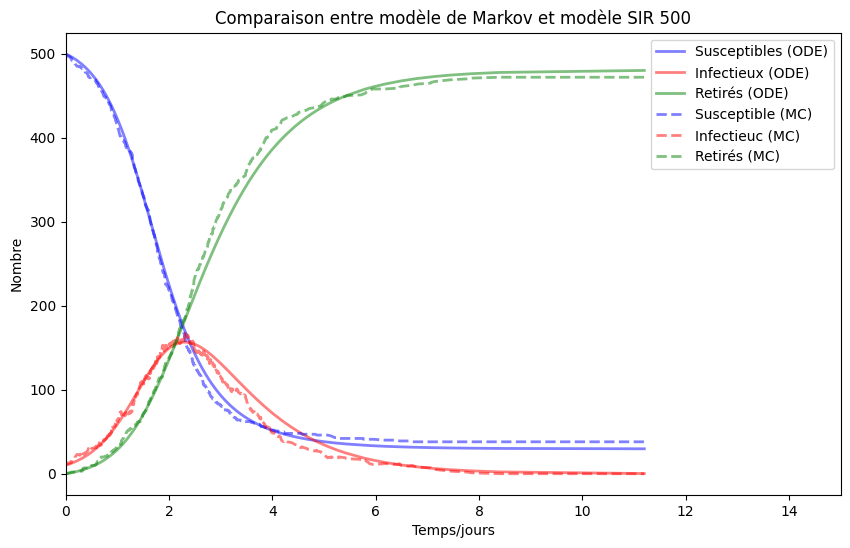

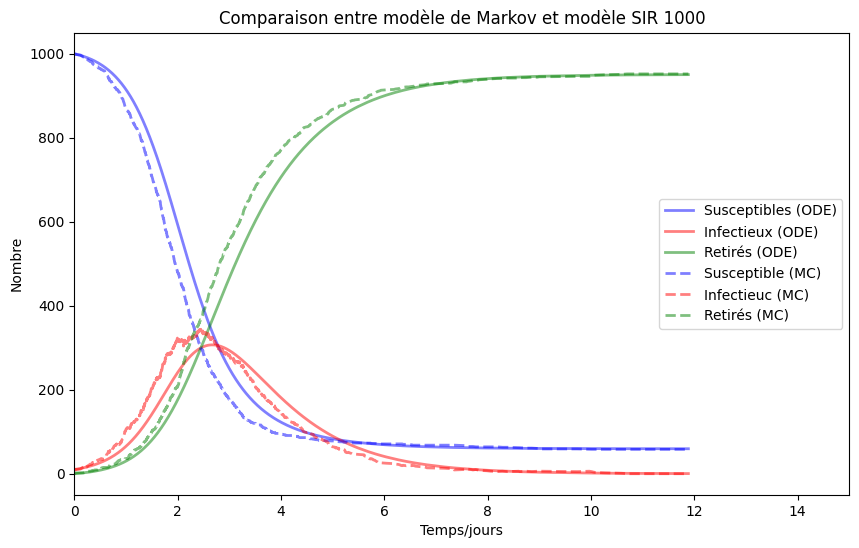

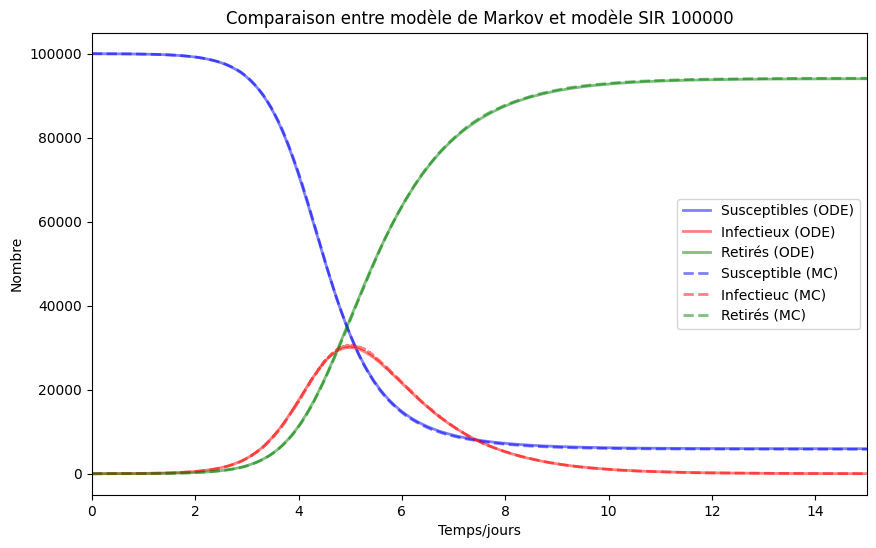

In [89]:
N_values=[500,1000,100000]
for N in N_values:
    fig = plt.figure(facecolor='w', figsize=(10, 6))
    T,L = trajectoire([N,10,0],200,3,1)
    x = odeint(SIR, [N , 10 ,0], T, args=(3,1,N+10))
    plt.plot(T, x[:, 0], 'b', alpha=0.5, lw=2, label='Susceptibles (ODE)')
    plt.plot(T, x[:, 1], 'r', alpha=0.5, lw=2, label='Infectieux (ODE)')
    plt.plot(T, x[:, 2], 'g', alpha=0.5, lw=2, label='Retirés (ODE)')
    variable_1 = [item[0] for item in L]
    variable_2 = [item[1] for item in L]
    variable_3 = [item[2] for item in L]
    plt.plot(T, variable_1, 'b--', alpha=0.5, lw=2, label='Susceptible (MC)')
    plt.plot(T, variable_2, 'r--', alpha=0.5, lw=2, label='Infectieuc (MC)')
    plt.plot(T, variable_3, 'g--', alpha=0.5, lw=2, label='Retirés (MC)')
    plt.xlim(0, 15)
    plt.xlabel('Temps/jours')
    plt.ylabel('Nombre')
    plt.title('Comparaison entre modèle de Markov et modèle SIR ' + str(N))
    plt.legend()
    plt.show()

On remarque graphiquement que le modèle de Markov converge vers le modèle SIR pour des valeurs de N croissantes

**5) Etude de la convergence du modèle markovien.**


On aimerait prouver le résultat du cours :
Soit $X_N$ le processus de markov $SIR$ pour une population de N+1 individus.

Pour tout $T$ >0 , on a $ lim_{{N \to \infty}} \sup \left\| \frac{{X_N(t)}}{N} - x(t) \right\|_{L^1} = 0$

On a essayé alors de tracer le $\sup \left\| \frac{{X_N(t)}}{N} - x(t) \right\| $ sur t<T en fonction de N nombre d'individus et prouver que ça tend vers O lorsque la population est trop grande 
(N=100000)

In [73]:
def convergence_markov(N_max):
    H = np.linspace(70000, N_max,40)
    list=[]
    difference=[]
    
    for i in H :
        T,L = trajectoire([i,10,0],200,beta,gamma)
        g = odeint(SIR, [i , 10 ,0], T, args=(beta, gamma,i+10))
        for a ,b in zip(g ,L ):
          list+=[(np.abs(a[0]-b[0])+np.abs(a[1]-b[1])+np.abs(a[2]-b[2]))/(i+10)]
        difference.append(max(list))
        list=[]
    return(H,difference)
  
  

difference is [1.4776753080727378, 1.3328367411674353, 1.3534492543643677, 1.3675798464839055, 1.3834904349702304, 1.229140389947609, 1.3939276599169887, 1.0930425755087674, 1.473724084256493, 1.208041819847769, 1.0674392532433483, 1.218523241654412, 0.9400879985274444, 1.0939194160867496, 1.0512722971554265, 1.0610868823103237, 1.125415795163355, 0.8964068662255521, 0.9229606824850823, 0.8789823009602572, 0.8290833934294896, 0.6632893507360147, 1.2244998626994814, 0.6926399657678052, 0.5626722933344311, 0.7042938880730292, 1.0021354556455375, 0.4996264190847584, 0.8094741169948427, 0.5239451591439221, 0.6603273411197763, 0.43767597546911546, 0.49738031955339407, 0.3315152280784043, 0.13761558740179813, 0.09839106788249853, 0.7525557857752553, 0.10568320408972755, 0.1606616934483576, 0.02780047924445069]


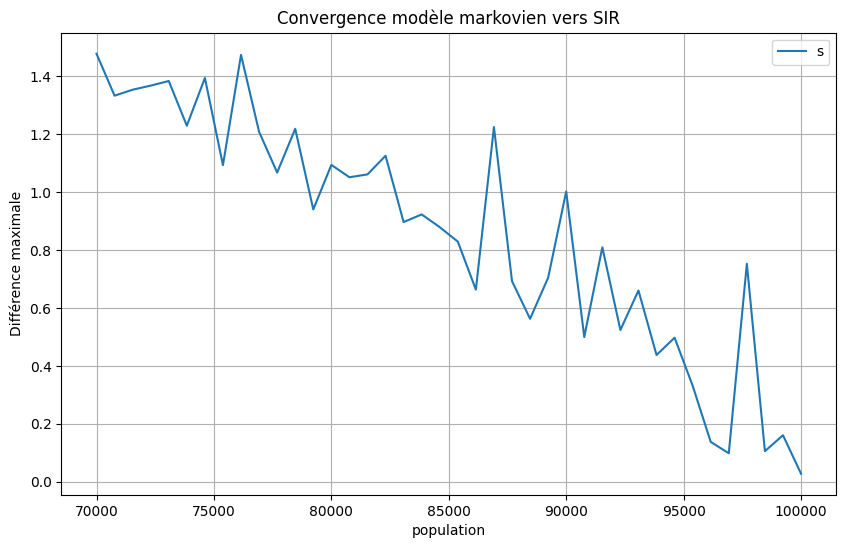

In [74]:
N1,D1=  convergence_markov(100000)
print("difference is",D1)
plt.figure(figsize=(10, 6))
plt.plot(N1, D1, label='s')


plt.xlabel('population')
plt.ylabel('Différence maximale')
plt.title('Convergence modèle markovien vers SIR')
plt.legend()
plt.grid(True)
plt.show()

On remarque une décroissance globale de différence en valeur absolue entre les deux modèles pour des valeurs croissantes de N (Les petites croissances qui apparaissent proviennent du caractère aléatoire du processus)

***6) Estimation des paramètres gamma et beta sur un département donné à partir des données sur COVID***

D'abord , on extrait les données du fichier **donnees-covid.cvs**, la fonction ci dessous prend commme paramètre ***i***, qui désigne ici le numéro du département choisit dans notre étude.

In [75]:

def données_département(i):
    # Initialise liste por chaque colonne
    hospitalisation = []
    réanimation = []
    décès = []
    retournés = []

    # Lecture de données
    with open('donnees-covid.csv', 'r') as file:
        reader = csv.reader(file, delimiter=';')
        next(reader)  # Skip the header row
        for row in reader:
            # choisit département i
            if row[0] == str(i):
                
                hospitalisation.append(int(row[2]))
                réanimation.append(int(row[3]))
                décès.append(int(row[4]))
                retournés.append(int(row[5]))

    return [hospitalisation,réanimation,décès,retournés]

On considère ici que les infectés sont les personnes hospitalisées et admises en réanimation, tandis que les retirés sont les décédés et les retournés, on adapte don nos données avec la fonction suivante

In [76]:
def données_adaptés(i):
    infectieux= [x + y for x, y in zip(données_département(i)[0], données_département(i)[1])]
    retirés=[x + y for x, y in zip(données_département(i)[2], données_département(i)[3])]
    return [infectieux,retirés]

Maintenant, pour pouvoir visualiser l'évolution des susceptibles, infectieux et retirés,, on utilise les règles suivantes:


>Le nombre d'infectieux jusqu'au jour $(i)$ = = nombre d'infectieux jusqu'au jour $(i-1)$  $+$ nombre de nouveaux infectieux du jour $(i)$ $-$ nombre de retirés du jour $(i)$.

>Le nombre de retirés jusqu'au jour $(i)$ = nombre de retirés jusqu'au jour $(i-1)$  $+$ nombre de retirés du jour $(i)$. 

>Le nombre de susceptible jusqu'au jour $(i)$ = population $-$ nombre infectieux jusqu'au jour $(i)$ $-$ nombre retirés jusq'au jour $(i)$.

In [77]:
# On construit donc les listes d'évolutions
def évolution(i,population):
    I=données_adaptés(i)[0]
    R=données_adaptés(i)[1]
    évolution_i=[1]
    évolution_s=[population]
    évolution_r=[0]
    for j in range(1,len(données_département(i)[0])):
        évolution_i+=[évolution_i[j-1]+I[j]-R[j]]
        évolution_r+=[évolution_r[j-1]+R[j]]
        évolution_s+=[population-évolution_i[j]-évolution_r[j]]
    
    return([évolution_s,évolution_i,évolution_r])

In [78]:
# Plotting
def plot_evolution_1(i, population):
    évolution_s, évolution_i, évolution_r = évolution(i, population)
    days = range(len(évolution_s))
    
    plt.figure(figsize=(10, 6))
    plt.plot(days, évolution_s, label='Susceptibles')
    plt.plot(days, évolution_i, label='Infectieux')
    plt.plot(days, évolution_r, label='Retirés')
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title('Evolution de population')
    plt.legend()
    plt.grid(True)
    plt.show()

On a choisit ci dessous le premier département de france qui disposait d'une population d'environ  660 000 en 2020, mais on a choisit une population de 3000, ceci était juste pour pouvoir visualiser les variations, qui ne serait plus visible pour un choix de population réaliste.

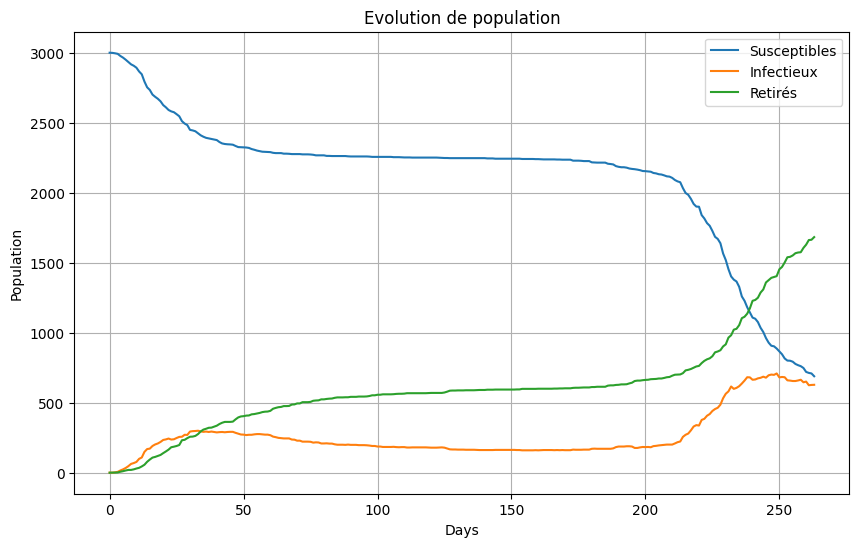

In [79]:
plot_evolution_1(1, 3000) 

On remarque la présence d'une deuxième vague  qui débute aux alentours du jour 180, on choisit donc d'étudier seule la première vague (car sinon modèle SIR non adapté)

La fonction ci dessous permet de faire ceci en choisissant la variable jour aux alentours de 100

In [80]:
def évolution_vague1(i,population):
    évolution_i_1=évolution(i,population)[1][:100]
    évolution_r_1=évolution(i,population)[2][:100]
    évolution_s_1=évolution(i,population)[0][:100]
    return([évolution_s_1,évolution_i_1,évolution_r_1])

1) Supposant que la diffusion du covid suit le modèle $SIR$, on a :

    $$-s'(t)/s(t)i(t) = \beta\   et\  r'(t)/i(t) =\gamma$$

Pour estimer donc $\beta$ et $\gamma$, on visualisera  $f_1(t)=-s'(t)/s(t)i(t)$ et $f_2(t)=r'(t)/i(t)$ et on étudiera leurs valeurs pour en tirer des valeurs approchée de  $\beta$ et $\gamma$

    

**Première approche :**

On va essayer de trouver $\gamma$ et $\beta$ en approchant les équations suivantes  
1) $s'(t) = -\beta s(t) i(t)$ et 
2) $r'(t) = \gamma i(t)$  
par :

 $(s_{n+1}- s_{n})/h_{n}= -\beta s_{n} i_{n}$ avec $h_{n}= t_{n+1}- t_{n}$ et $s_{n}$ le nombre des susceptibles au jour $t_{n}$

 
 Et De meme pour la deuxième équation, on l'approche par :
 
 $(r_{n+1}- r_{n})/h_{n}= \gamma i_{n} $ avec $h_{n}= t_{n+1}- t_{n}$ et $r_{n}$ le nombre des retirés au jour $t_{n}$

In [81]:
#Fonction qui renvoie les valeurs de béta en utilisant l'approche décrite ci-dessus
def val_beta(S1, I1, t0, tN, steps,population):
    t = np.linspace(t0, tN, steps + 1)
    h = t[1]-t[0]
    var = []
    beta = []
    for i in range(steps):
        if i+1 < len(S1):
            var_i = (S1[i+1]-S1[i]) / h
            var.append(var_i)
            beta_i = var_i / (S1[i] * I1[i])
            beta.append(-beta_i*population)
    return beta

#Fonction qui renvoie les valeurs de gamma en utilisant l'approche décrite ci-dessus
def val_gamma(r, I, t0, tN, steps):
    t = np.linspace(t0, tN, steps + 1)
    # Defining the steps h
    h = t[1]-t[0]
    var = []
    gamma = []
    for i in range(steps):
        if i+1 < len(r):
            var_i = (r[i+1]-r[i]) / h
            var.append(var_i)
            gamma_i = var_i / (I[i])
            gamma.append(gamma_i)
    return gamma


On tronque la liste vue qu'on étudie que la première vague où le modèle SIR est applicable

Ce code teste la fonction sur le département 1 , avec nombre de population N=660000 (population du département 1) en prenant une data tronquée qui modélise la première vague

Valeurs de Beta pour chaque jour [0.003666753752068278, 0.0036802400462220305, 0.01116386777882621, 0.029550741421386185, 0.018469437491229816, 0.02192082708741989, 0.01450811904017186, 0.014508207061922544, 0.0036535487622158754, 0.00368041867372165, 0.0036804242561104187, 0.018676808135753457, 0.007760345024939809, -0.0, -0.0, 0.016211944050296672, -0.0, 0.00408609640382965, 0.008172205203329728, -0.0, -0.0, -0.0, 0.00874321549660232, -0.0, -0.0, 0.004509464915912008, 0.00905975321108711, 0.018625223568823537, -0.0, -0.0, -0.0, 0.019160035232111454, -0.0, 0.004813066899062928, -0.0, -0.0, -0.0, -0.0, -0.0, 0.010061501844707763, 0.004980708809198555, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.005107775455132976, 0.010320881523379628, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.01088183200983876, -0.0, -0.0, 0.005500722978356788, 0.005470672681124212, -0.0, -0.0, 0.00556185899575074, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.005592939317481243, 0.005561875869043105, 0.00553115

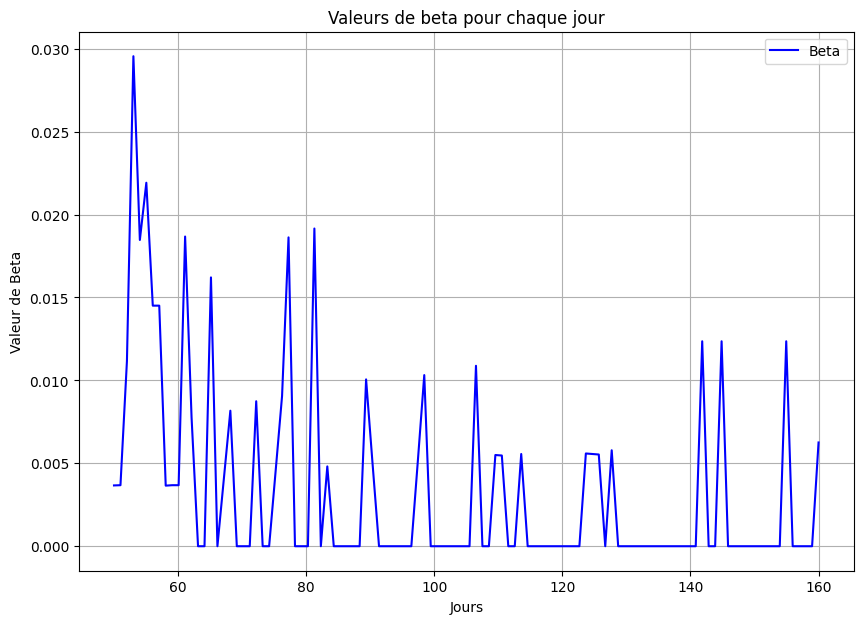

Valeurs de Beta pour chaque jour [0.007326007326007326, 0.014705882352941176, 0.0037174721189591076, 0.02952029520295203, 0.007380073800738007, 0.014598540145985401, 0.014492753623188406, 0.021739130434782608, 0.010948905109489052, 0.003676470588235294, 0.01838235294117647, 0.055970149253731345, 0.023255813953488372, 0.01968503937007874, 0.008032128514056224, 0.024291497975708502, 0.0, 0.004081632653061225, 0.04081632653061224, 0.004219409282700422, 0.029661016949152543, 0.0, 0.039301310043668124, 0.0, 0.0, 0.009009009009009009, 0.03619909502262444, 0.009302325581395349, 0.004608294930875576, 0.032407407407407406, 0.0, 0.014354066985645933, 0.009523809523809525, 0.004807692307692308, 0.02403846153846154, 0.014778325123152709, 0.0, 0.0, 0.005, 0.0, 0.014925373134328358, 0.0, 0.0, 0.010050251256281407, 0.0, 0.0, 0.005076142131979695, 0.015306122448979591, 0.02577319587628866, 0.0, 0.020942408376963352, 0.0, 0.016042780748663103, 0.0, 0.0, 0.0, 0.005434782608695652, 0.010810810810810811, 

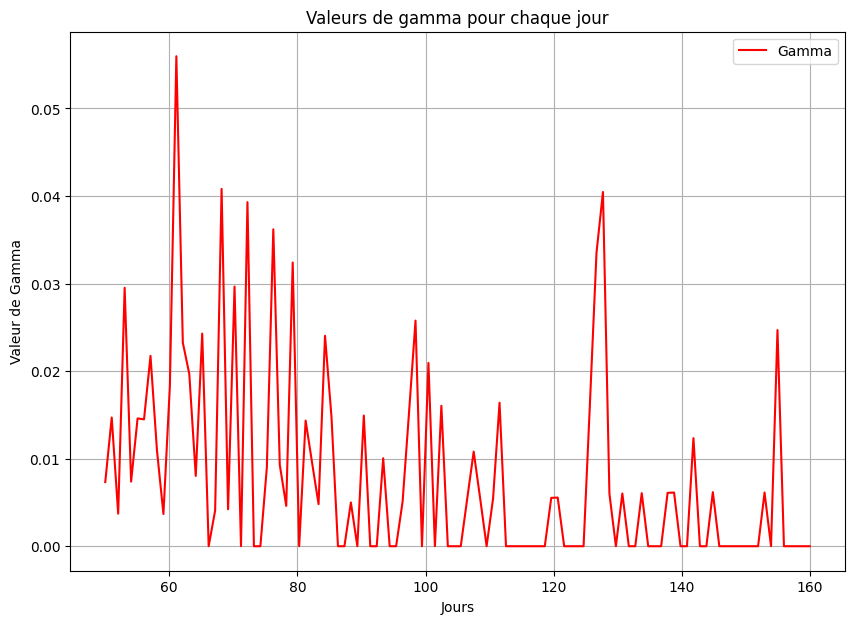

In [82]:
t0=50
tN=160
steps=160-50
t = np.linspace(t0, tN, steps)
s=évolution(1,660000)[0][49 :160]
i=évolution(1,660000)[1][49 :160]
r=évolution(1,660000)[2][49 :160]

# Calculer les valeurs de beta
beta_values = val_beta(s, i, t0, tN, steps,660000)

# Calculer les valeurs de beta
gamma_values = val_gamma(r, i, t0, tN, steps)

# Afficher les résultats
print("Valeurs de Beta pour chaque jour",beta_values)

# Créer la première figure pour Béta
plt.figure(figsize=(10, 7))
plt.plot(t, beta_values, color='blue', label='Beta')
plt.xlabel("Jours")
plt.ylabel("Valeur de Beta")
plt.title("Valeurs de beta pour chaque jour")
plt.legend()
plt.grid()
plt.show()


# Créer la deuxième figure pour gamma
print("Valeurs de Beta pour chaque jour",gamma_values)
plt.figure(figsize=(10, 7))
plt.plot(t, gamma_values, color='red', label='Gamma')
plt.xlabel("Jours")
plt.ylabel("Valeur de Gamma")
plt.title("Valeurs de gamma pour chaque jour")
plt.legend()
plt.grid()
plt.show()

On peut alors estimer la valeur de  ($\beta$ , $\gamma$ ) pour le département 1 pour la première vague :

(0.015 , 0.0125) 


On remarque , que ces valeurs sont trop petits vue que dans la première vague le nombre des infectés était trop petit par rapport au nombre de la population du premier département.

**Deuxième approche :**

Pour éviter les oscillations dans les valeurs éstimées de $\beta$ et $\gamma$, on approche les functions $s'$, $r'$, $s$, $i$ (utilisées dans $f_1(t)=-s'(t)/s(t)i(t)$ et $f_2(t)=r'(t)/i(t)$) par des fonctions continues polynomiales (On utilisera une interpolation polynomiale ). On pourra ainsi tracer les fonctions $f_1(t)$ et $f_2(t)$ et estimer des valeurs possibles de $\beta$ et $\gamma$.

La fonction ci-dessous (derivative) effectue ceci, elle prend en paramètre le degré de la fonction polynomiale qui approchera nos données,le numéro de  département choisi $i$ (on choisira 1 par la suite) et la population du département choisi ( le département 1 avait une opulation de 660000 en 2020)

In [83]:

def derivative(i,population,degree):
    x_data = [i for i in range(100)]
    y_data_s = évolution_vague1(i, population)[0]
  
    y_data_i = évolution_vague1(i, population)[1]
    y_data_r = évolution_vague1(i, population)[2]
    coefficients_s = np.polyfit(x_data, y_data_s, degree)
    
    coefficients_i = np.polyfit(x_data, y_data_i, degree)
    coefficients_r = np.polyfit(x_data, y_data_r, degree)
    polynomial_func_s = np.poly1d(coefficients_s) ## fonction s approchée 
    polynomial_func_i = np.poly1d(coefficients_i) ## fonction i approchée 
    polynomial_func_r = np.poly1d(coefficients_r)
    derivative_poly_s = np.polyder(polynomial_func_s) # fonction s' approchée 
    derivative_poly_i = np.polyder(polynomial_func_i)
    derivative_poly_r = np.polyder(polynomial_func_r) # fonction r' approchée 
    return [derivative_poly_s,derivative_poly_i,derivative_poly_r,polynomial_func_s,polynomial_func_i,polynomial_func_r]






In [84]:
# La fonction f_1
def béta_function(t,i,population,degree):
    derivée_s=derivative(i,population,degree)[0]
    s=derivative(i,population,degree)[3]
    inf=derivative(i,population,degree)[5]
    return -derivée_s(t)/(s(t)*inf(t))

In [85]:
# La fonction f_2
def gamma_function(t,i,population,degree):
    inf=derivative(i,population,degree)[5]
    derivée_r=derivative(i,population,degree)[2]
    return derivée_r(t)/inf(t)

0.022156088638691198
0.01887544582775733
0.01637344977962907
0.014469815540164221
0.013018520570132083
0.011899881852914894
0.011014169420034985
0.010276332239391263
0.009612035325677469
0.00895550120524642
0.008249672340241923
0.007449058664660491
0.006525427217151751
0.005476336307307231
0.004336440065488073
0.0031913402804390656
0.002193098120966932


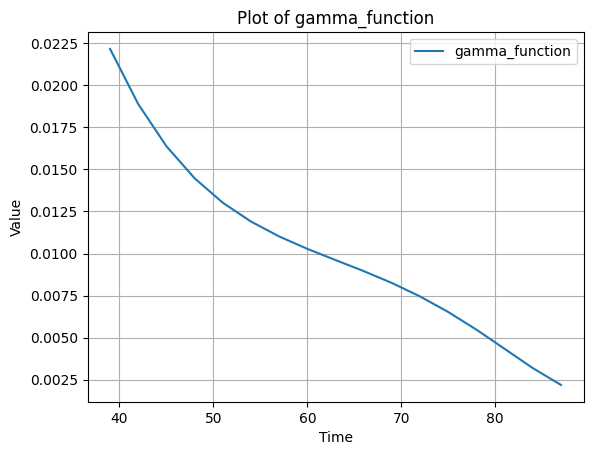

0.021566121315654524
0.01684411001770236
0.013401841021257107
0.01083774461769223
0.00886096088105771
0.007269547609231186
0.005935132290510669
0.004789002336645492
0.0038071352061894597
0.0029934920982203138
0.0023622462807527797
0.0019205668480421015
0.0016541863728789389
0.0015183854685074185
0.0014375388478392323
0.0013174817182217476
0.0010772027853054866


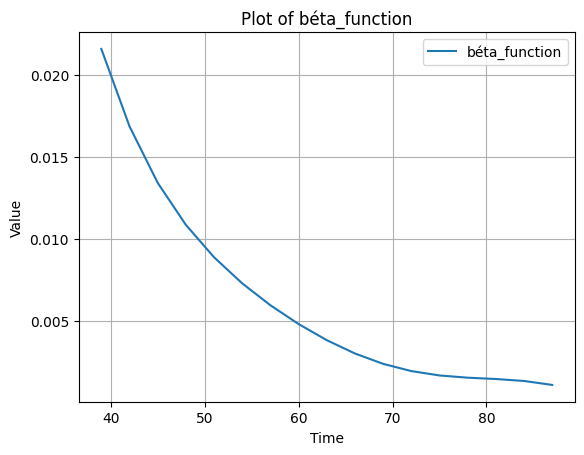

In [88]:
# Tracé des fonctions f_1 et f_2

t_values = [3*i for i in range(13,30)]
A=[]

# Calculate the gamma_function values
for j in t_values:
    A.append(gamma_function(j, 1, 3000, 10))
    print(gamma_function(j, 1, 3000, 10))

# Plot the gamma_function
plt.plot(t_values, A, label='gamma_function')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Plot of gamma_function')
plt.legend()
plt.grid(True)
plt.show()
 
B=[]

# Calculate the béta_function values
for j in t_values:
    B.append(béta_function(j, 1, 660000, 10)*660000)
    print(béta_function(j, 1, 660000, 10)*660000)

# Plot the béta_function
plt.plot(t_values, B, label='béta_function')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Plot of béta_function')
plt.legend()
plt.grid(True)
plt.show()

D'après les tracés on peut estimer $\beta$ et $\gamma$ par les valeurs suivants (moyenne): $\beta = 0.012 $ et $\gamma =0.01 $



Il nous semble que le paramètre gamma est loin de la réalité, vue qu'une infection Covid dure approximativement 15 jours, alors que notre gamma renvoie vers une durée de 100 jours

Si à partir des données , on avait accès au régime permanent(disparition d'infectieux selon modèle SIR ) , on aurait pu vérifier les valeurs trouvées en évaluant le rapport $R_0 = \beta / \gamma$ qui devrait satisfaire l'équation :
$\ 1 - r(\infty) = e^{-R_0 \cdot r(\infty)}$

#### Le tracé de gamma et béta n'est pas quasi constant ou même proche de quasi constant, ceci renvoie vers une non adaptabilité du modèle SIR pour ces données COVID (pour le département 1 en tout cas).


$$**Fin**$$